In [1]:
import os
from prometheus_client import Gauge
from prometheus_api_client import PrometheusConnect, MetricSnapshotDataFrame
from prometheus_api_client.utils import parse_datetime
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

load_dotenv()

True

In [2]:
prom = PrometheusConnect(url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)

start_time = parse_datetime("12h")
end_time = parse_datetime("9h")

In [13]:
requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('nginx_vts_server_request_seconds', start_time=start_time, end_time=end_time, label_config={'host': '172.16.2.108'}, chunk_size=timedelta(seconds=15)))


req_dataframe = requests_seconds[['timestamp', 'value']].copy()
req_dataframe['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in req_dataframe['timestamp']]
req_dataframe['value'] = [float(value) for value in req_dataframe['value']]

req_dataframe = req_dataframe.set_index('timestamp')
req_dataframe = req_dataframe.asfreq('15S')

Train dates : 2022-05-06 07:35:13.879000 --- 2022-05-06 08:37:58.879000  (n=252)
Test dates  : 2022-05-06 08:38:13.879000 --- 2022-05-06 08:46:58.879000  (n=36)


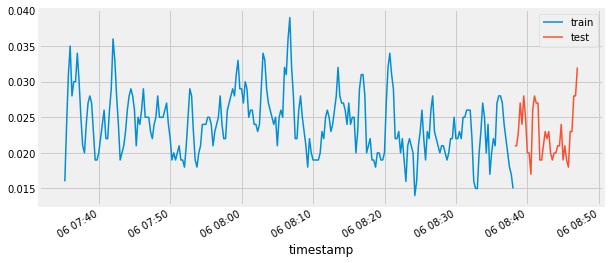

In [14]:
steps = 36 # 36 * 15seg = 9min
data_train = req_dataframe[:-steps]
data_test  = req_dataframe[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend()

In [15]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import warnings
# warnings.filterwarnings('ignore')

In [21]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 20 # 20 * 15seg = 5min, para usar como predição
                )

forecaster.fit(y=data_train['value'])

In [22]:
steps_prediction = 36 # 36 * 15seg = 9min no futuro
predictions = forecaster.predict(steps=steps_prediction)
predictions.head(5)

2022-05-06 08:38:13.879    0.01835
2022-05-06 08:38:28.879    0.02009
2022-05-06 08:38:43.879    0.02158
2022-05-06 08:38:58.879    0.02190
2022-05-06 08:39:13.879    0.02183
Freq: 15S, Name: pred, dtype: float64

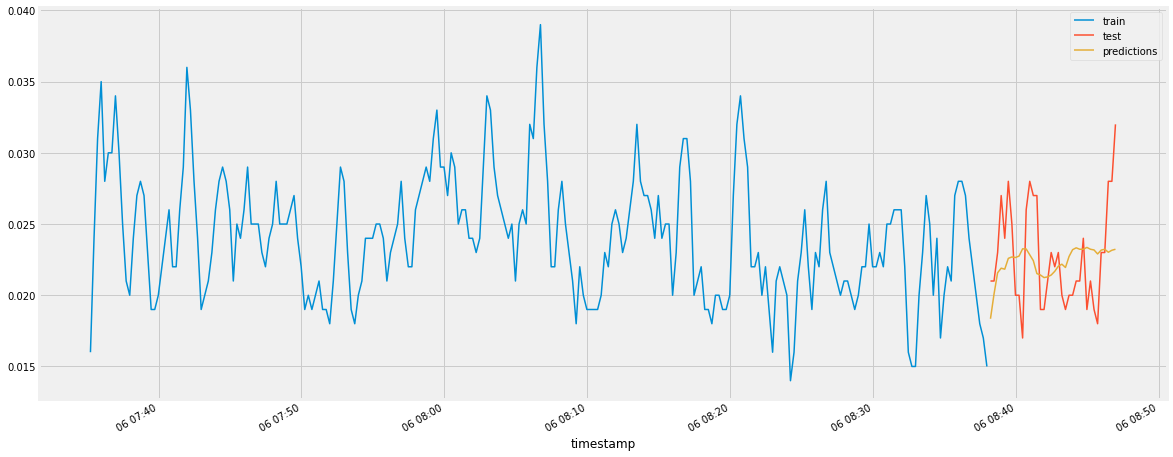

In [23]:
fig, ax = plt.subplots(figsize=(18, 8))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()